<a href="https://colab.research.google.com/github/Narayana27/covidpred/blob/master/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification

## Clone the Github Repo to access the Dataset

In [ ]:
!git clone https://github.com/Ashish-Arya-CS/Coursera-Content.git

Cloning into 'Coursera-Content'...
remote: Enumerating objects: 3049, done.
remote: Counting objects: 100% (3049/3049), done.
remote: Compressing objects: 100% (3046/3046), done.
remote: Total 3049 (delta 1), reused 3043 (delta 0), pack-reused 0
Receiving objects: 100% (3049/3049), 79.25 MiB | 24.17 MiB/s, done.
Resolving deltas: 100% (1/1), done.


## Import necessary Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils



## Creating Directories to store Cropped Images

In [ ]:
# Create Directory for Training Data
os.mkdir("/content/Crop-Brain-MRI")
os.mkdir("/content/Crop-Brain-MRI/glioma_tumor")
os.mkdir("/content/Crop-Brain-MRI/meningioma_tumor")
os.mkdir("/content/Crop-Brain-MRI/no_tumor")
os.mkdir("/content/Crop-Brain-MRI/pituitary_tumor")

In [ ]:
# Create Directory for Testing Data
os.mkdir("/content/Test-Data")
os.mkdir("/content/Test-Data/glioma_tumor")
os.mkdir("/content/Test-Data/meningioma_tumor")
os.mkdir("/content/Test-Data/no_tumor")
os.mkdir("/content/Test-Data/pituitary_tumor")

([<matplotlib.axis.XTick at 0x7f586923f410>,
 [Text(0, 0, 'glioma_tumor'),
  Text(0, 0, 'meningioma_tumor'),
  Text(0, 0, 'no_tumor'),
  Text(0, 0, 'pituitary_tumor')])

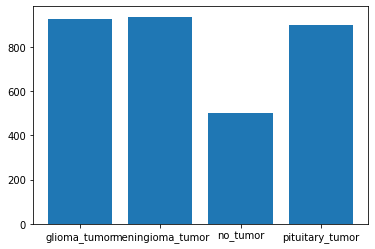

In [ ]:
# Matplotlib
>>> import matplotlib.pyplot as plt
>>> import numpy as np
>>> images_count = [926, 937, 501, 901]
>>> images_types = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
>>> tree_pos = np.arange(len(images_types))
>>> plt.bar(tree_pos, images_count)
>>> plt.xticks(tree_pos, images_types)

([<matplotlib.patches.Wedge at 0x7ff0ce72bd90>,
 [Text(-0.8554708272269668, 0.6914981299783893, 'glioma_tumor'),
  Text(-0.48637903261267246, -0.9866283173691911, 'meningioma_tumor'),
  Text(0.8789059159896009, -0.6614562652500018, 'no_tumor'),
  Text(0.8385908441839212, 0.7118745648292955, 'pituitary_tumor')],
 [Text(-0.4666204512147091, 0.3771807981700305, '28%'),
  Text(-0.2652976541523668, -0.5381609003831951, '29%'),
  Text(0.47940322690341863, -0.36079432650000093, '15%'),
  Text(0.45741318773668416, 0.3882952171796156, '28%')])

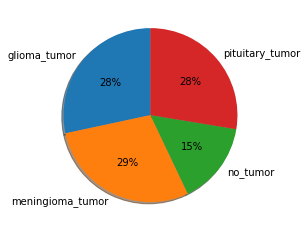

In [ ]:
>>> import matplotlib.pyplot as plt
>>> name = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
>>> count = [926, 937, 501, 901]
>>> plt.pie(count, labels=name, autopct='%0.f%%', shadow=True, startangle=90)

## Data Visualization

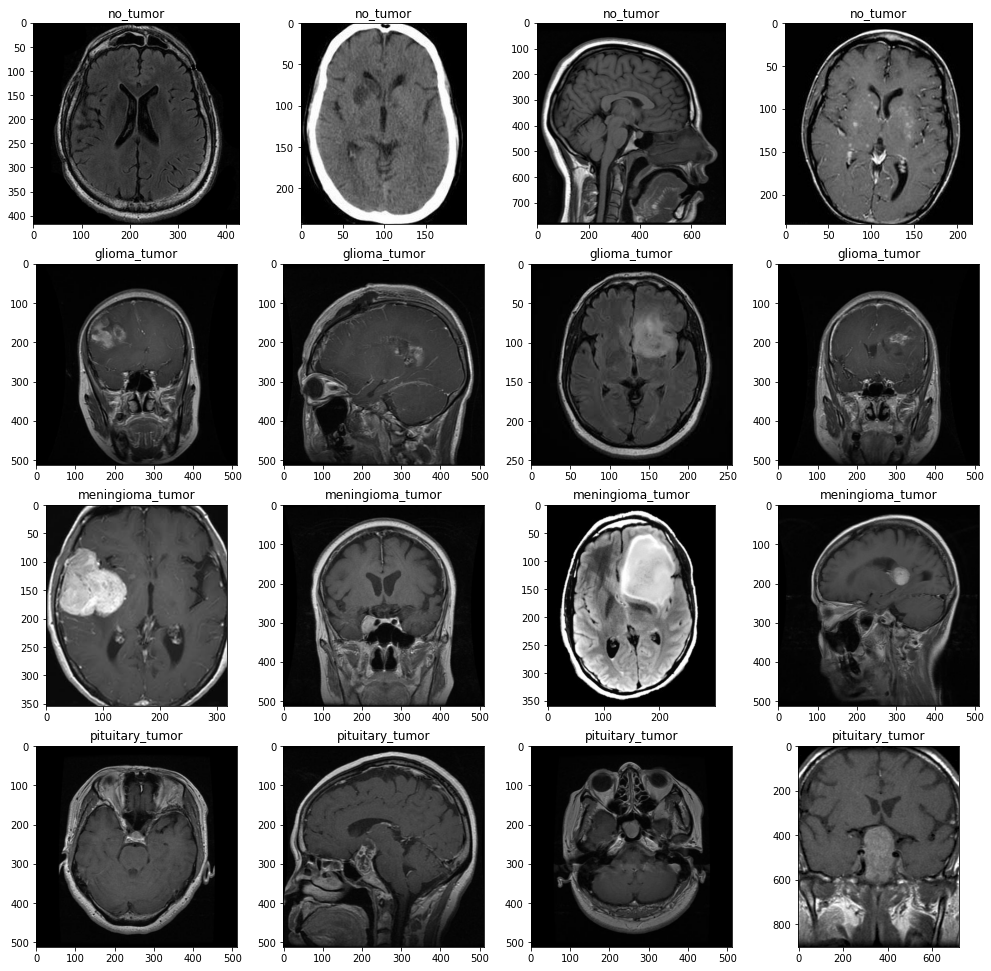

In [ ]:
train_dir="/content/Coursera-Content/Brain-MRI/Training/"
test_dir="/content/Coursera-Content/Brain-MRI/Testing/"
classes=os.listdir("/content/Coursera-Content/Brain-MRI/Training")
files_path_dict={}

for c in classes:
  files_path_dict[c]=list(map(lambda x: train_dir+c+'/'+x, os.listdir(train_dir+c)))

plt.figure(figsize=(17,17))
index=0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list=files_path_dict[c][:5]

  for i in range(1,5):
    index += 1
    plt.subplot(4,4,index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)


## Create a Function to Crop Images

In [ ]:
def crop_image(image, plot=False):

    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)

    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image


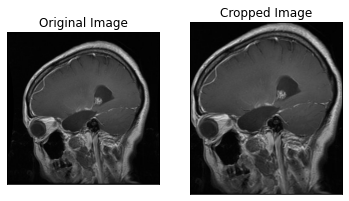

In [ ]:
example_img=cv2.imread("/content/Coursera-Content/Brain-MRI/Training/glioma_tumor/gg (101).jpg")
cropped_img=crop_image(example_img, plot=True)

## Saving The Cropped Images

In [ ]:
# Crop the Training Images and Save it to the Directory we previously cretaed
glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
no_tumor = train_dir + "no_tumor"
pituitary = train_dir + "pituitary_tumor"

j=0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j=0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j=0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j=0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1


100%|██████████| 901/901 [00:06<00:00, 143.82it/s]


In [ ]:
# Crop the Testing Images and Save it to the Directory we previously cretaed
test_glioma = test_dir + "glioma_tumor"
test_meningioma = test_dir + "meningioma_tumor"
test_no_tumor = test_dir + "no_tumor"
test_pituitary = test_dir + "pituitary_tumor"

j=0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Data/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j=0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Data/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j=0
for i in tqdm(os.listdir(test_no_tumor)):
  path = os.path.join(test_no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Data/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j=0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Data/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1


100%|██████████| 5/5 [00:00<00:00, 100.31it/s]


## Perform Data Augmentation and Prepare the Train, Validation and Test Dataset

In [ ]:
# Use Image Data Generator to perform this task.
datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/', target_size = (224,224), batch_size = 32,
                                         class_mode= 'categorical', subset= 'training')
valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/', target_size = (224,224), batch_size = 32,
                                         class_mode= 'categorical', subset= 'validation')
test_datagen = ImageDataGenerator()
test_data = datagen.flow_from_directory('/content/Test-Data/', target_size = (224,224),
                                         class_mode= 'categorical')

Found 2613 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [ ]:
# View the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


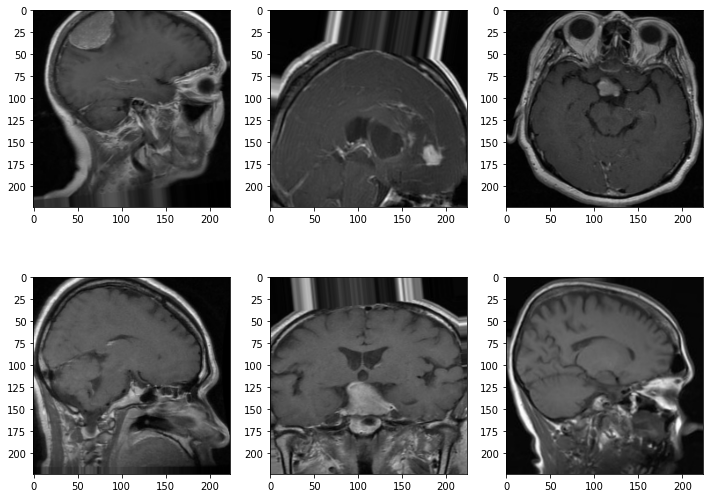

In [ ]:
# View the augmented data.
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12,9))
for i in range(6):
  plt.subplot(2,3,i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('on')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

# Build and Compile the Model

In [ ]:

# Build the Model
effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224,224,3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= effnet.input, outputs= model)

model.summary()

27025408/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5,mode="auto", verbose=1)

## Model Training and Model Evaluation

In [ ]:
# Train the model
history = model.fit(train_data, epochs=7, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop])

Epoch 1/7
82/82 [==============================] - 793s 10s/step - loss: 0.9065 - accuracy: 0.6406 - val_loss: 0.7610 - val_accuracy: 0.7086

Epoch 00001: val_accuracy improved from -inf to 0.70859, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/7
82/82 [==============================] - 776s 9s/step - loss: 0.3846 - accuracy: 0.8752 - val_loss: 0.4366 - val_accuracy: 0.8420

Epoch 00002: val_accuracy improved from 0.70859 to 0.84202, saving model to model.h5
Epoch 3/7
82/82 [==============================] - 776s 9s/step - loss: 0.2318 - accuracy: 0.9219 - val_loss: 0.3517 - val_accuracy: 0.8712

Epoch 00003: val_accuracy improved from 0.84202 to 0.87117, saving model to model.h5
Epoch 4/7
82/82 [==============================] - 775s 9s/step - loss: 0.1659 - accuracy: 0.9422 - val_loss: 0.2818 - val_accuracy: 0.9018

Epoch 00004: val_accuracy improved from 0.87117 to 0.90184, saving model to model.h5
Epoch 5/7
82/82 [==============================] - 775s 9s/step - loss: 0.1337 - accuracy: 0.9541 - val_loss: 0.2210 - val_accuracy: 0.9156

Epoch 00005: val_accuracy improved from 0.90184 to 0.91564, saving model to model.h5
Epoch 6/7
82/82 [==============================] - 775s 9s/step - loss: 0.0935 - accuracy: 0.970

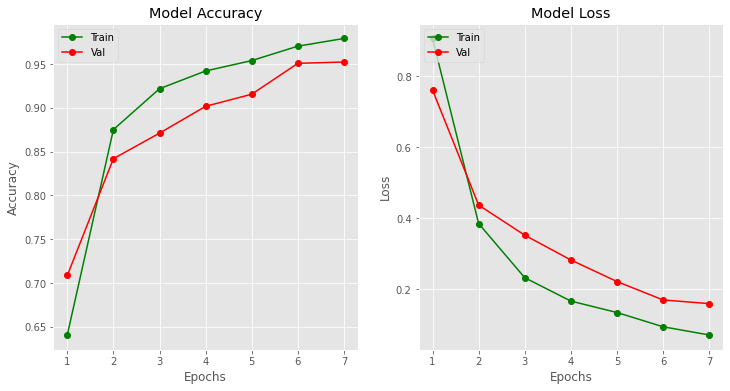

In [ ]:
# Plot the training curves
plt.style.use("ggplot")
plt.figure(figsize=(12,6))
epochs = range(1,8)
plt.subplot(1, 2,1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Val"], loc="upper left")

plt.subplot(1, 2,2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","Val"], loc="upper left")
plt.show()


In [ ]:
# Evaluate the model on Test Set
model.evaluate(test_data)

1/1 [==============================] - 1s 1s/step - loss: 0.1365 - accuracy: 0.9500


[0.13648009300231934, 0.949999988079071]

## Obtaining Predictions on Test Images

glioma_tumor


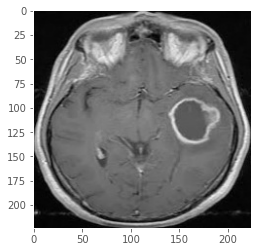

In [ ]:
# Obtain Predictions on Test Images
class_dict = {0: "glioma_tumor", 1: "meningioma_tumor", 2:"no_tumor", 3:"pituitary_tumor"}

test_img1 = cv2.imread("/content/Test-Data/glioma_tumor/4.jpg")
plt.imshow(test_img1)
plt.grid(False)
test_img1 = np.expand_dims(test_img1, axis=0)
pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)

In [ ]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!git clone https://github.com/aksh-ai/neuralBlack

Cloning into 'neuralBlack'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 184 (delta 81), reused 151 (delta 53), pack-reused 0
Receiving objects: 100% (184/184), 6.44 MiB | 20.35 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [ ]:
!pwd

/content
